In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Reads Data

In [2]:
data = pd.read_csv("./dataset_diabetes/diabetic_data.csv")
data.shape

(101766, 50)

In [3]:
data.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [4]:
data.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Cleaning

In [5]:
# replace Null string like ? or 'NULL' to numpy NaN object
none_kinds = ['?','NULL','None']
data = data.replace(to_replace=none_kinds,value=np.nan)

# replace NULL ids according to mappings desciription 
admission_type_id_null_values = [5,6,8]
discharge_disposition_id_null_values = [18,25,26]
admission_source_id_null_values = [9,17,20,21]
data['admission_type_id'] = data['admission_type_id'].replace(to_replace=admission_type_id_null_values,value=np.nan)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(to_replace=discharge_disposition_id_null_values,value=np.nan)
data['admission_source_id'] = data['admission_source_id'].replace(to_replace=admission_source_id_null_values,value=np.nan)

In [6]:
# check for data sparse precentage 
(data.isnull().sum() / data.shape[0])

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.102156
discharge_disposition_id    0.045988
admission_source_id         0.069444
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
A1Cresult                   0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

We decided to drop every feature that as less than 80% data

In [7]:
features_to_remove = (data.isnull().sum() / data.shape[0]) > 0.2
features_to_remove = features_to_remove[features_to_remove].index.values
features_to_remove

array(['weight', 'payer_code', 'medical_specialty', 'max_glu_serum',
       'A1Cresult'], dtype=object)

In [8]:
data.drop(features_to_remove,axis=1,inplace=True)

In [9]:
data.shape

(101766, 45)

### remove Nan's

replace Nan's ids according to mappings desciription with new category callend 'Unknown' mapped as zero
for the features: admission_type_id, discharge_disposition_id, admission_source_id

In [10]:
# 0 -> 'Unknown'
data[['admission_type_id','discharge_disposition_id','admission_source_id']] = data[['admission_type_id','discharge_disposition_id','admission_source_id']].fillna(0)

'race' feature is categorical feature. In order to fill Nan's, we will fill it with the string 'Unknown'.

In [11]:
data['race'] = data['race'].fillna('Unknown')

The last coulmns contains Nan's are diag1, diag2, diag3. let's see what is the perentage of Nan's according the entire data

In [12]:
data.isnull().values.ravel().sum() / data.shape[0]

0.017707289271465913

We got that only 1.7% of the data contains Nan's so we decided to remove those samples

In [13]:
data = data.dropna()

### handle data duplications of records 

In [14]:
len(data['patient_nbr'].unique()) , len(data['encounter_id'].unique())

(70416, 100244)

So we see we have 70413 distinct patients but there is 100241 encounters (records). it means that some patients have more than 1 record. so we dont want our models to treat a patient with multiples encounters independently, becuase we think that it will lead to bias results.

we thoughts about 2 main approaches to deal with multiple encounters.
1. take only the last encounter
2. take only the first encounter
becuase that the readmitted feature is imbalnaced (only 11% are considerd readmitted) if we will pick the first approach it will increase the imbalanced of the data, becuase the last encounter of a patient means the the value of his readmitted feature is 'NO'. thus we decided to take the second approach (taking only the first encounter). in this approach we decreases the imbalanced data.

In [15]:
data = data.drop_duplicates(subset='patient_nbr',keep='first')

we got that after removing multiple encounters for same patient (taking the first encounter) we got 70413 records.

## Data exploration 

lets look on demographic data, first lets look on gender distribution 

In [16]:
data.groupby('gender').size()

gender
Female             37480
Male               32933
Unknown/Invalid        3
dtype: int64

we see there is 3 Unkwon's in the data so we consinder them as outliers and we will remove them

In [17]:
data = data[data['gender'] != 'Unknown/Invalid']

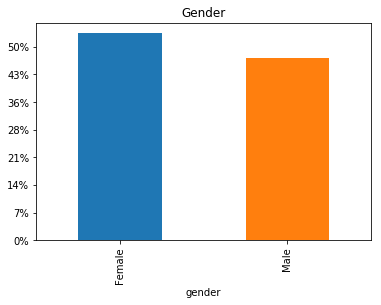

In [18]:
ax = data.groupby('gender').size().plot(kind='bar',title='Gender')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
ax

we can see that the gender distrubution is almost Uniformic

Now let's explore the race feature

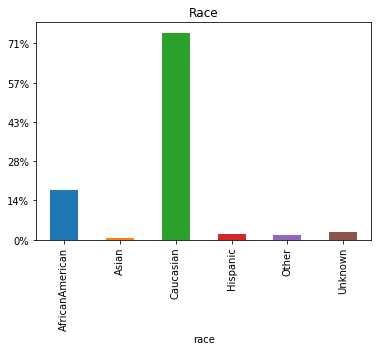

In [19]:
ax = data.groupby('race').size().plot(kind='bar',title='Race')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
ax

we can see that more than 72% of the patients are Caucasian's and almost 16% are African Americans 

so lets look on the relation between race and gender

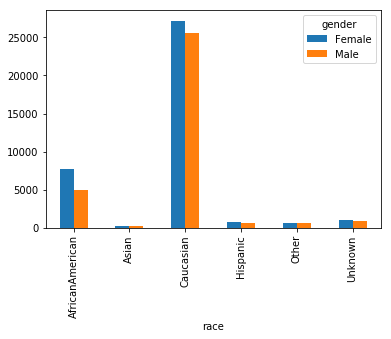

In [20]:
pd.crosstab(data['race'],data['gender']).plot(kind='bar')

so we can see also here that the distribution between gender and race is also almost Uniformic

now let's plot age feature

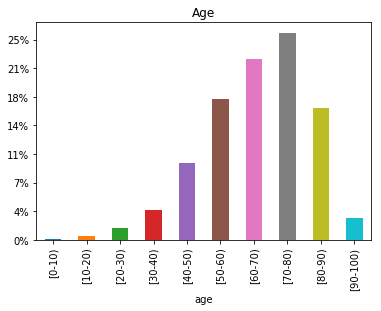

In [21]:
ax = data.groupby('age').size().plot(kind='bar',title='Age')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
ax

We can see that the majority of the patients are between age of 50-90.

so now let's look on readmitted feature

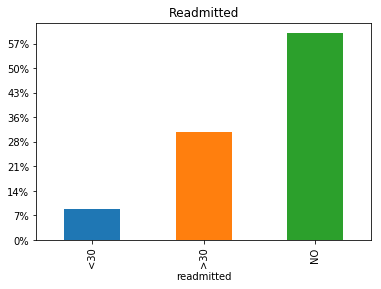

In [22]:
ax = data.groupby('readmitted').size().plot(kind='bar',title='Readmitted')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
ax

we can see that the majority of patients are not readdmited, but maybe some of them died? or maybe cured.
about 31% readmitted after more than 30 days and only 8% readmitted less than 30 days.
the readimitted feature is imbalanced.

let's explore the readmitted feature inside each age range

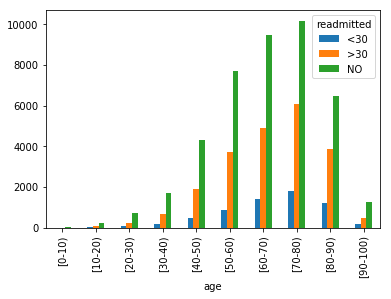

In [23]:
pd.crosstab(data['age'],data['readmitted']).plot(kind='bar')

as we can see the distribution of readmission in each age range stays almost Normal, just like the agr distribution itself.

now we going to explore the change medications feature 

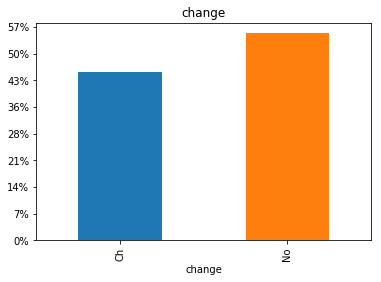

In [24]:
ax = data.groupby('change').size().plot(kind='bar',title='change')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
ax

we can see that the change medications distrubution is almost Uniformic

lets look on the relation between change medications and readmitted status 

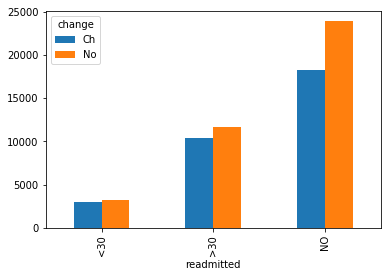

In [25]:
pd.crosstab(data['readmitted'],data['change']).plot(kind='bar')

as we can see, patients that readmitted again ('<30','>30') divide half by half about changing their medications, but about patients that not readmitted intend less to change their medications, but still alot of them changed.

## Data Engineering 

Now let's prepare the data for running models. we will decide which features are important for training, and convert the categorical features to numeric. let's split the data to numeric and categorial 

In [26]:
categorical_data = data.select_dtypes('object')
numeric_data = data[list(filter(lambda col: col not in categorical_data.columns,data.columns))]

### handle categorical Data

There are 23 (after data cleaning) drugs columns in the dataset:
'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
'tolazamide', 'examide', 'insulin', 'glyburide-metformin',
'glipizide-metformin', 'glimepiride-pioglitazone',
'metformin-rosiglitazone', 'metformin-pioglitazone'.
each of these drugs features indicate if a change in that medication was made or not during the patient visit in the hospital, in order to use those features and reduce the number of dimensions we decided to create a new feature that sums the number of changes in medication dosage for each patient, and drop those features. we believe that if the medication dosage changed during the patient visit its realated to diabetes disease.

In [27]:
drugs_data = categorical_data[['metformin', 'citoglipton', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']]
for col in drugs_data.columns:
    drugs_data[col] = drugs_data[col].apply(lambda val: 0 if val == 'No' or val == 'Steady' else 1)
categorical_data['number_drugs_changed'] = drugs_data.sum(axis=1)
categorical_data = categorical_data.drop(drugs_data.columns,axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


all the binary features that categorical (gender,change,diabetesMed) we will change to numeric (1 and 0)

In [28]:
categorical_data['gender'] = categorical_data['gender'].replace('Male', 1)
categorical_data['gender'] = categorical_data['gender'].replace('Female', 0)
categorical_data['change'] = categorical_data['change'].replace('Ch', 1)
categorical_data['change'] = categorical_data['change'].replace('No', 0)
categorical_data['diabetesMed'] = categorical_data['diabetesMed'].replace('Yes', 1)
categorical_data['diabetesMed'] = categorical_data['diabetesMed'].replace('No', 0)

for the age feature, we going to take the middle value of each age range (for example '40-50' -> 45)
we do that because we show that the demographic data is pretty almost Uniformic so we believe that also the distribution of each age range is also Uniformic.

In [29]:
categorical_data['age'] = categorical_data['age'].replace('[0-10)', 5)
categorical_data['age'] = categorical_data['age'].replace('[10-20)', 15)
categorical_data['age'] = categorical_data['age'].replace('[20-30)', 25)
categorical_data['age'] = categorical_data['age'].replace('[30-40)', 35)
categorical_data['age'] = categorical_data['age'].replace('[40-50)', 45)
categorical_data['age'] = categorical_data['age'].replace('[50-60)', 55)
categorical_data['age'] = categorical_data['age'].replace('[60-70)', 65)
categorical_data['age'] = categorical_data['age'].replace('[70-80)', 75)
categorical_data['age'] = categorical_data['age'].replace('[80-90)', 85)
categorical_data['age'] = categorical_data['age'].replace('[90-100)', 95)

for the race feature we going to change this feature to dummies feature (like One Hot Encoding).

In [30]:
race_dummies_data = pd.get_dummies(categorical_data['race'])
categorical_data = categorical_data.drop('race',axis=1)
categorical_data = pd.concat([categorical_data,race_dummies_data],axis=1)

for the readmitted feature, we saw that only about 10% readmitted <30 and most of thae patients readmitted >30 or not readmitted at all. therefore we think that patients that readmitted >30 is not highly related to the first readmission (can be a different cause). so we decided to consider 'readmitted' only patients that readmitted <30 days.

In [31]:
categorical_data['readmitted'] = categorical_data['readmitted'].replace('NO', 0)
categorical_data['readmitted'] = categorical_data['readmitted'].replace('>30', 0)
categorical_data['readmitted'] = categorical_data['readmitted'].replace('<30', 1)

### Handle Numeric Data

from numeric data we have 3 features that numeric but we consoder them categorical features
'admission_type_id', 'discharge_disposition_id', 'admission_source_id'. for the features 'discharge_disposition_id' and 'admission_source_id' there are too many categories and we think we will get bias results with too many features to include so we decided to drop those features.

for 'admission_type_id', on the cleaning part we combined 'Not Available','NULL' and 'Not Mapped' to new category called 0. we also going to combine 'Emergency','Urgent' and 'Trauma Center' to one categorty called 'Emergency'.

In [32]:
# combining the 'admission_type_id' categories 2->1 and 7->1
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(2,1)
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(7,1)

# reanme numbers to categories
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(0,'Not Available')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(1,'Emergency')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(3,'Elective')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(4,'Newborn')

# transform 'admission_type_id' to dummies (one Hot Enconding)
numeric_data = pd.get_dummies(numeric_data,'admission_type_id')

# drop 'discharge_disposition_id', 'admission_source_id'
numeric_data = numeric_data.drop(['discharge_disposition_id','admission_source_id'],axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

lets combine numeric_data and categorical_data

In [33]:
combined_data = pd.concat([numeric_data,categorical_data],axis=1)
##### Todo: remove this or Handle this
combined_data = combined_data.drop(['diag_1','diag_2','diag_3'],axis=1)

the encounter_id and patient_nbr are not features that part of the modeling, so we will set them as index features.

In [34]:
combined_data = combined_data.set_index(['encounter_id','patient_nbr'])

### Using Standard Scaler

we are going to use standard scaling over all numeric data (that not binary).

In [35]:
numeric_not_binary_columns = ['age','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses','number_drugs_changed']
scaler = StandardScaler()
scaler.fit(combined_data[numeric_not_binary_columns])
combined_data[numeric_not_binary_columns] = scaler.transform(combined_data[numeric_not_binary_columns])
combined_data.head(5)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,admission_type_id_Elective,admission_type_id_Emergency,...,change,diabetesMed,readmitted,number_drugs_changed,AfricanAmerican,Asian,Caucasian,Hispanic,Other,Unknown
encounter_id,patient_nbr,,,,,,,,,,,,,,,,,,,,,
149190,55629189,-0.445300,0.793048,-0.817697,0.263550,-0.263416,-0.204306,-0.298994,0.882073,0,1,...,1,1,0,1.550530,0,0,1,0,0,0
64410,86047875,-0.783494,-1.609837,2.013535,-0.338804,1.596207,-0.204306,1.345137,-0.703078,0,1,...,0,1,0,-0.550936,1,0,0,0,0,0
500364,82442376,-0.783494,0.042147,-0.251451,0.022608,-0.263416,-0.204306,-0.298994,-0.174695,0,1,...,1,1,0,1.550530,0,0,1,0,0,0
16680,42519267,-1.121687,0.392567,-0.817697,-0.941158,-0.263416,-0.204306,-0.298994,-1.231462,0,1,...,1,1,0,-0.550936,0,0,1,0,0,0
35754,82637451,-0.445300,-0.608635,2.579781,0.022608,-0.263416,-0.204306,-0.298994,0.882073,0,1,...,0,1,0,-0.550936,0,0,1,0,0,0


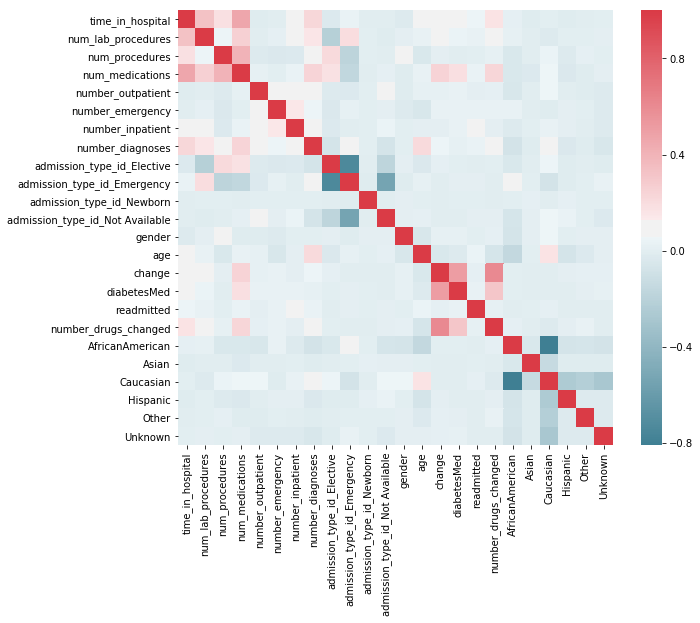

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
corr = combined_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Clustering Part

In [45]:
def plot_3d_scatter(data,labels):
    fig1 = plt.figure()
    ax1 = Axes3D(fig1)
    ax1.scatter(data[:,1], data[:,0], data[:,2],c=labels)

    fig2 = plt.figure()
    ax2 = Axes3D(fig2)
    ax2.scatter(data[:,0], data[:,1], data[:,2],c=labels)

    plt.show()

KMeans

In [39]:
kmeans_model = KMeans(n_clusters=4,n_jobs=-1)
kmeans_model.fit(combined_data.values)
centers = kmeans_model.cluster_centers_

In [40]:
kmeans_pca = PCA(n_components=3)
kmeans_pca_data = kmeans_pca.fit_transform(combined_data)

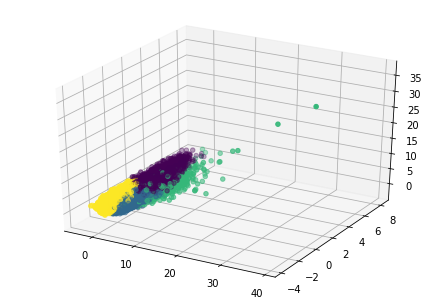

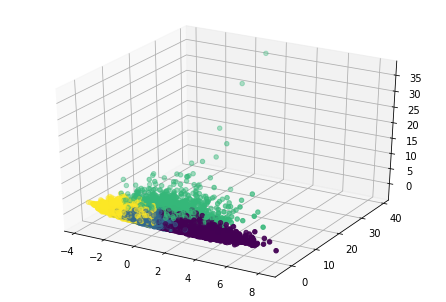

In [46]:
plot_3d_scatter(kmeans_pca_data,kmeans_model.labels_)

Agglomerative Clustering

In [47]:
knn = kneighbors_graph(combined_data,10,n_jobs=-1)
Agglomerative_model = AgglomerativeClustering(n_clusters=4,connectivity=knn)
Agglomerative_model.fit(combined_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<70413x70413 sparse matrix of type '<class 'numpy.float64'>'
	with 704130 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [48]:
agglomerative_pca = PCA(n_components=3)
agglomerative_pca_data = agglomerative_pca.fit_transform(combined_data)

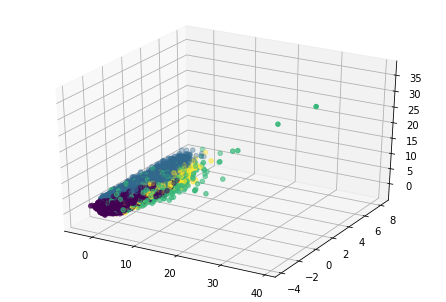

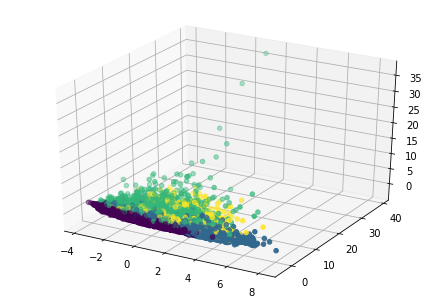

In [49]:
plot_3d_scatter(agglomerative_pca_data,Agglomerative_model.labels_)

Spectral Clustering

In [ ]:
spectral_model = SpectralClustering(n_clusters=4,n_jobs=-1)
spectral_model.fit(combined_data.values)

In [ ]:
spectral_pca = PCA(n_components=3)
spectral_pca_data = spectral_pca.fit_transform(combined_data)